In [1]:
# Mount google drive

from google.colab import drive
drive.mount('/content/drive')

#%pip install scikit-learn lxml

import pandas as pd
import json
import os
import glob
from lxml import etree

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
#%pip install sentence-transformers

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity


Mounted at /content/drive


In [2]:
# File paths
main_directory = "/content/drive/My Drive/266_NLP/final project/"
directory = "/content/drive/My Drive/266_NLP/final project/uspto_patents"
#output_json = "/content/drive/My Drive/266_NLP/final project/uspto_patents_metadata.json"
output_csv = "/content/drive/My Drive/266_NLP/final project/uspto_patents_metadata.csv"


In [ ]:
import os
import glob
from lxml import etree
import json
import pandas as pd

def extract_all_claims(root):
    claims = root.findall(".//claims/claim")
    all_claims = []
    for claim in claims:
        parts = claim.findall(".//claim-text")
        claim_text = " ".join(p.text.strip() for p in parts if p.text)
        all_claims.append(claim_text)  # Removed claim_number
    return all_claims

def extract_patent_metadata(xml_path):
    try:
        tree = etree.parse(xml_path)
        root = tree.getroot()

        def gettext(xpath):
            el = root.find(xpath)
            return el.text.strip() if el is not None and el.text else None

        def getalltext(xpath):
            els = root.findall(xpath)
            return [el.text.strip() for el in els if el is not None and el.text]

        # Fetch all parts together
        sections = getalltext(".//classification-cpc/section")
        classes = getalltext(".//classification-cpc/class")
        subclasses = getalltext(".//classification-cpc/subclass")
        main_groups = getalltext(".//classification-cpc/main-group")
        subgroups = getalltext(".//classification-cpc/subgroup")

        # Zip CPC levels to produce full identifiers
        cpc_entries = list(zip(sections, classes, subclasses, main_groups, subgroups))

        def safe_join(*parts, sep=""):
            return sep.join(p for p in parts if p)

        metadata = {
            "file": os.path.basename(xml_path),
            "publication_number": gettext(".//publication-reference/document-id/doc-number"),
            "application_number": gettext(".//application-reference/document-id/doc-number"),
            "publication_date": gettext(".//publication-reference/document-id/date"),
            "application_date": gettext(".//application-reference/document-id/date"),
            "invention_title": gettext(".//invention-title"),

            # Construct full identifiers
            "section": sorted(set(sections)),
            "class": sorted(set(safe_join(s, c) for s, c, _, _, _ in cpc_entries if s and c)),
            "subclass": sorted(set(safe_join(s, c, sc) for s, c, sc, _, _ in cpc_entries if s and c and sc)),
            "main_group": sorted(set(safe_join(s, c, sc, mg) for s, c, sc, mg, _ in cpc_entries if s and c and sc and mg)),
            "subgroup": sorted(set(safe_join(s, c, sc, mg, "-" + sg) for s, c, sc, mg, sg in cpc_entries if s and c and sc and mg and sg)),

            "country": gettext(".//country"),
            "abstract": gettext(".//abstract/p"),
            "assignee": gettext(".//assignees/assignee/addressbook/orgname"),
            "inventor_1": gettext(".//inventors/inventor[1]/addressbook/last-name"),
            "inventor_2": gettext(".//inventors/inventor[2]/addressbook/last-name"),
            "claims": extract_all_claims(root),
        }

        return metadata
    except Exception as e:
        return {"file": os.path.basename(xml_path), "error": str(e)}


def extract_from_directory(directory):
    xml_files = glob.glob(os.path.join(directory, "*.xml"))
    print(f"Found {len(xml_files)} XML files in {directory}")
    return [extract_patent_metadata(path) for path in xml_files]

if not os.path.exists(output_csv):

  # Extract
  records = extract_from_directory(directory)

  # Save JSON
  #with open(output_json, "w", encoding="utf-8") as f:
  #    json.dump(records, f, indent=2)

  # Save CSV
  df = pd.DataFrame(records)
  df["section"] = df["section"].apply(lambda x: ",".join(sorted(set(x))) if isinstance(x, list) else x)
  df["claims"] = df["claims"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")
  df["combined_text"] = (
      df["invention_title"].fillna("") + " " +
      df["abstract"].fillna("") + " " +
      df["claims"]
  ).str.lower()

  df.to_csv(output_csv, index=False)

  print(f"Extracted {len(records)} files. Saved to JSON and CSV.")
  del records

In [3]:
df_all=pd.read_csv(main_directory + "uspto_patents_metadata.csv")
df_all = df_all.dropna(subset=['section'])
df_cleaned, test_df = train_test_split(df_all, test_size=0.15, random_state=42)#, stratify=df_all['section'], random_state=42)

df_cleaned = df_cleaned.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

df_cleaned.head()



,file,publication_number,application_number,publication_date,application_date,invention_title,section,class,subclass,main_group,subgroup,country,abstract,assignee,inventor_1,inventor_2,claims,combined_text
0,doc_5361.xml,20250199513,18845342.0,20250619,20230305.0,COOLING SYSTEM CONTROL FOR DATA CENTER HEAT REUSE,G,['G05'],['G05B'],"['G05B19', 'G05B2219']","['G05B19-4155', 'G05B2219-50333']",US,A system and methods are provided for controll...,NaN,BELKIN,NaN,"multiple evaporators units (EUs), each configu...",cooling system control for data center heat re...
1,doc_4615.xml,20250198777,18798839.0,20250619,20240809.0,"PATH FINDING METHOD, PATH FINDING APPARATUS, A...",G,['G01'],['G01C'],['G01C21'],['G01C21-3469'],US,A path finding method capable of determining a...,NaN,KIM,LEE,setting a destination for a transport vehicle ...,"path finding method, path finding apparatus, a..."
2,doc_3936.xml,20250198099,18981374.0,20250619,20241213.0,SUSTAINABLE BARRIERS,"C,E","['C08', 'E01']","['C08L', 'E01F']","['C08L17', 'C08L2207', 'E01F15']","['C08L17-00', 'C08L2207-24', 'E01F15-086', 'E0...",US,A sustainable barrier including a waste materi...,NaN,Davis,Welle,a waste material; and a binder mixed with the ...,sustainable barriers a sustainable barrier inc...
3,doc_3341.xml,20250197603,18808870.0,20250619,20240819.0,REFRIGERATOR,"C,F","['C08', 'F25']","['C08G', 'C08K', 'F25D']","['C08G18', 'C08G2110', 'C08G2330', 'C08K2201',...","['C08G18-73', 'C08G2110-0025', 'C08G2330-00', ...",US,A refrigerator may include a main body includi...,"Samsung Electronics Co., Ltd.",HIRANO,TAKEUCHI,a main body including: an inner cabinet that f...,refrigerator a refrigerator may include a main...
4,doc_622.xml,20250195064,19067868.0,20250619,20250301.0,Surgical Staple Implant Kit,"A,B","['A61', 'B65']","['A61B', 'B65B']","['A61B17', 'A61B2017', 'A61B2090', 'A61B50', '...","['A61B17-068', 'A61B17-0682', 'A61B17-10', 'A6...",US,An apparatus and a method are provided for a s...,"In2Bones USA, LLC",Wahl,Taylor,a staple inserter and a surgical staple; a gro...,surgical staple implant kit an apparatus and a...


In [4]:
df_cleaned

,file,publication_number,application_number,publication_date,application_date,invention_title,section,class,subclass,main_group,subgroup,country,abstract,assignee,inventor_1,inventor_2,claims,combined_text
0,doc_5361.xml,20250199513,18845342.0,20250619,20230305.0,COOLING SYSTEM CONTROL FOR DATA CENTER HEAT REUSE,G,['G05'],['G05B'],"['G05B19', 'G05B2219']","['G05B19-4155', 'G05B2219-50333']",US,A system and methods are provided for controll...,NaN,BELKIN,NaN,"multiple evaporators units (EUs), each configu...",cooling system control for data center heat re...
1,doc_4615.xml,20250198777,18798839.0,20250619,20240809.0,"PATH FINDING METHOD, PATH FINDING APPARATUS, A...",G,['G01'],['G01C'],['G01C21'],['G01C21-3469'],US,A path finding method capable of determining a...,NaN,KIM,LEE,setting a destination for a transport vehicle ...,"path finding method, path finding apparatus, a..."
2,doc_3936.xml,20250198099,18981374.0,20250619,20241213.0,SUSTAINABLE BARRIERS,"C,E","['C08', 'E01']","['C08L', 'E01F']","['C08L17', 'C08L2207', 'E01F15']","['C08L17-00', 'C08L2207-24', 'E01F15-086', 'E0...",US,A sustainable barrier including a waste materi...,NaN,Davis,Welle,a waste material; and a binder mixed with the ...,sustainable barriers a sustainable barrier inc...
3,doc_3341.xml,20250197603,18808870.0,20250619,20240819.0,REFRIGERATOR,"C,F","['C08', 'F25']","['C08G', 'C08K', 'F25D']","['C08G18', 'C08G2110', 'C08G2330', 'C08K2201',...","['C08G18-73', 'C08G2110-0025', 'C08G2330-00', ...",US,A refrigerator may include a main body includi...,"Samsung Electronics Co., Ltd.",HIRANO,TAKEUCHI,a main body including: an inner cabinet that f...,refrigerator a refrigerator may include a main...
4,doc_622.xml,20250195064,19067868.0,20250619,20250301.0,Surgical Staple Implant Kit,"A,B","['A61', 'B65']","['A61B', 'B65B']","['A61B17', 'A61B2017', 'A61B2090', 'A61B50', '...","['A61B17-068', 'A61B17-0682', 'A61B17-10', 'A6...",US,An apparatus and a method are provided for a s...,"In2Bones USA, LLC",Wahl,Taylor,a staple inserter and a surgical staple; a gro...,surgical staple implant kit an apparatus and a...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8871,doc_9191.xml,20250203340,18843579.0,20250619,20220504.0,ROUTE SELECTION POLICY RULES FOR VISITED NETWORKS,H,['H04'],['H04W'],"['H04W40', 'H04W48', 'H04W8', 'H04W84']","['H04W40-20', 'H04W48-18', 'H04W8-082', 'H04W8...",US,There is provided a network node in a first wi...,NaN,KARAMPATSIS,KUNZ,the network node comprising: at least one memo...,route selection policy rules for visited netwo...
8872,doc_6907.xml,20250201059,19072196.0,20250619,20250306.0,GAME SYSTEM FOR PROVIDING VARIABLE ODDS WITH I...,G,"['G06', 'G07']","['G06T', 'G07F']","['G06T7', 'G07F17']","['G06T7-70', 'G07F17-3209', 'G07F17-3211', 'G0...",US,The present invention generates at least one s...,NaN,HSU,WANG,an imaging unit configured to obtain a real-ti...,game system for providing variable odds with i...
8873,doc_7636.xml,20250201785,19062450.0,20250619,20250225.0,LIGHT EMITTING DEVICE WITH LED STACK FOR DISPL...,H,"['H01', 'H10']","['H01L', 'H10H']","['H01L25', 'H10H20']","['H01L25-0756', 'H01L25-13', 'H10H20-018', 'H1...",US,A light emitting diode pixel for a display inc...,"SEOUL VIOSYS CO., LTD.",JANG,LEE,a first subpixel comprising a first LED sub-un...,light emitting device with led stack for displ...
8874,doc_5051.xml,20250199203,18849773.0,20250619,20230210.0,THERMOPLASTIC RESIN AND OPTICAL MEMBER CONTAIN...,"C,G","['C08', 'G02']","['C08G', 'G02B']","['C08G64', 'G02B1']","['C08G64-1608', 'C08G64-307', 'G02B1-041']",US,The purpose of the present invention is to pro...,TEIJIN LIMITED,ISHIHARA,SATO,"where in the Formula (1), R where in the Formu...",thermoplastic resin and optical member contain...


In [5]:
import numpy as np
from sentence_transformers import SentenceTransformer

if not os.path.exists(main_directory + "all-MiniLM-L6-v2_embeddings.npy"):
  # Initialize embedding model
  embedder = SentenceTransformer("all-MiniLM-L6-v2")
  #embedder = SentenceTransformer("AI-Growth-Lab/PatentSBERTa")
  #embedder = SentenceTransformer("multi-qa-mpnet-base-dot-v1")
  #embedder = SentenceTransformer("intfloat/e5-base-v2")
  #Create embeddings
  embeddings = embedder.encode(df_cleaned["combined_text"].tolist())
  np.save(main_directory + "all-MiniLM-L6-v2_embeddings.npy", embeddings)
else:
    print("Embeddings already exist.")
    embeddings = np.load(main_directory + "all-MiniLM-L6-v2_embeddings.npy")

print(embeddings.shape)

Embeddings already exist.
(8876, 384)


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report

# Step 1: Preprocess labels (multi-label binarization)
# The filtering for missing 'section' values was already done when creating df_cleaned from df_all
# No need to dropna again here.

# Split section into list (if it's a comma-separated string)
df_cleaned['section_list'] = df_cleaned['section'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

# Binarize multi-label output
mlb = MultiLabelBinarizer(classes=["A", "B", "C", "D", "E", "F", "G", "H"])
Y = mlb.fit_transform(df_cleaned["section_list"])


# Step 2: Train-test split
# Since embeddings were created from df_cleaned (after the initial split and dropping missing sections),
# we can use the index of this df_cleaned directly as it corresponds to the embeddings.
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, Y, test_size=0.5, random_state=42
)

# Step 3: Train a One-vs-Rest classifier
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
clf.fit(X_train, y_train)

# Step 4: Predict and evaluate
y_pred = clf.predict(X_test)
print("Multi-label Section Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Y'] will be ignored
  warnings.warn(


Multi-label Section Classification Report:

              precision    recall  f1-score   support

           A       0.92      0.39      0.54       838
           B       0.95      0.16      0.27       776
           C       0.84      0.39      0.54       532
           D       0.00      0.00      0.00        22
           E       1.00      0.04      0.07       108
           F       1.00      0.07      0.14       276
           G       0.81      0.59      0.68      1527
           H       0.89      0.57      0.69      1540

   micro avg       0.86      0.44      0.58      5619
   macro avg       0.80      0.28      0.37      5619
weighted avg       0.88      0.44      0.55      5619
 samples avg       0.51      0.47      0.48      5619



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Drop missing section values
#df_cleaned = df.dropna(subset=['section'])

# Filter to known section labels only (A–H)
valid_sections = list("ABCDEFGH")
df_cleaned = df_cleaned[df_cleaned["section"].isin(valid_sections)]

# Prepare features and labels
X = embeddings[df_cleaned.index]
y = df_cleaned["section"]

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

# === CHOOSE ONE MODEL ===

# 1. Logistic Regression
model = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs')

# 2. Support Vector Machine
# model = SVC(kernel='linear', class_weight='balanced', probability=True)

# 3. Gradient Boosting
# model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# =========================

# Train model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Classification report
print("\nSection Classification Report:")
print(classification_report(y_test, y_pred, labels=valid_sections))



Section Classification Report:
              precision    recall  f1-score   support

           A       0.81      0.69      0.74       527
           B       0.63      0.58      0.60       379
           C       0.54      0.85      0.66       194
           D       0.25      0.40      0.31        10
           E       0.35      0.71      0.47        59
           F       0.41      0.70      0.52       146
           G       0.80      0.74      0.77       972
           H       0.84      0.77      0.81      1060

    accuracy                           0.73      3347
   macro avg       0.58      0.68      0.61      3347
weighted avg       0.75      0.73      0.73      3347



In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# import ast # Import the ast module

# # Step 1: Convert string representation of list to actual list and handle errors
# def parse_class_list(class_str):
#     try:
#         return ast.literal_eval(class_str) if isinstance(class_str, str) and class_str.strip() != "" else []
#     except (ValueError, SyntaxError):
#         return [] # Return empty list for invalid formats

# df_cleaned = df.copy()
# df_cleaned["class_list"] = df_cleaned["class"].apply(parse_class_list)
# df_cleaned = df_cleaned[df_cleaned["class_list"].apply(lambda x: isinstance(x, list) and len(x) > 0)].copy()

# # Step 2: Use the first class as the label
# df_cleaned["class_label"] = df_cleaned["class_list"].apply(lambda x: x[0])

# # Step 3: Identify and remove classes with only one sample
# class_counts = df_cleaned["class_label"].value_counts()
# classes_to_keep = class_counts[class_counts >= 2].index.tolist()
# df_filtered = df_cleaned[df_cleaned["class_label"].isin(classes_to_keep)].copy()

# # Step 4: Prepare features and labels
# X = embeddings[df_filtered.index] # Select embeddings corresponding to the filtered DataFrame
# y = df_filtered["class_label"]

# # Step 5: Train-test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# # Step 6: Train classifier
# clf = LogisticRegression(max_iter=1000, class_weight="balanced")
# clf.fit(X_train, y_train)

# # Step 7: Evaluate
# y_pred = clf.predict(X_test)
# print("\nClassification Report (class_label):")
# print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


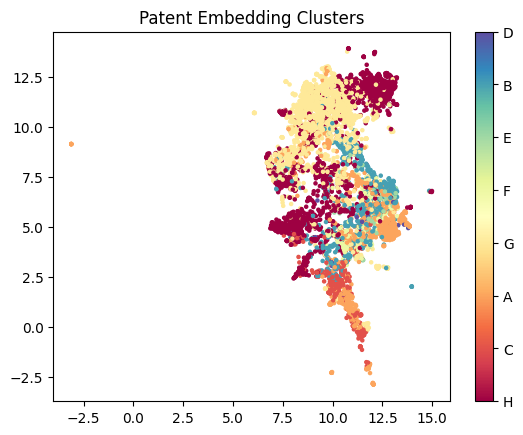

In [ ]:
# # %pip install numpy==2.2.0
# # %pip install umap-learn --upgrade

# import umap
# import matplotlib.pyplot as plt


# reducer = umap.UMAP(n_neighbors=15, random_state=42)
# # Compute UMAP projection only on embeddings corresponding to df_cleaned
# proj = reducer.fit_transform(embeddings[df_cleaned.index])

# # Define labels for coloring the scatter plot
# labels = df_cleaned["section"]

# # Map string labels to numerical values
# unique_labels = labels.unique()
# label_map = {label: i for i, label in enumerate(unique_labels)}
# numerical_labels = labels.map(label_map)


# plt.scatter(proj[:,0], proj[:,1], c=numerical_labels, cmap='Spectral', s=5)
# plt.title("Patent Embedding Clusters")
# # Add a colorbar to show the mapping of colors to sections
# cbar = plt.colorbar(ticks=np.arange(len(unique_labels)))
# cbar.ax.set_yticklabels(unique_labels)
# plt.show()

In [8]:
# # Finetune the embeddings
# # Create positive and negative pairs
# import pandas as pd
# from itertools import combinations
# import random

# #df_cleaned = df.dropna(subset=['section'])
# build_df_pairs = False

# if os.path.exists(main_directory + "df_pairs.csv"):
#     df_pairs = pd.read_csv(main_directory + "df_pairs.csv")
# else:
#     print("df_pairs.csv does not exist. Building...")
#     build_df_pairs = True

#     # Step 1
#     df_sample = df_cleaned[["section", "publication_number"]].sample(df_cleaned.shape[0], random_state=42)

#     # -----------------------------------------------
#     # STEP 2 — Generate all unique pairs
#     # -----------------------------------------------

#     positive_pairs = []
#     negative_pairs = []
# #    count=0
#     # Use itertools.combinations to get all unique pairs
#     for row1, row2 in combinations(df_sample.itertuples(index=False), 2):
#         # Always sort publication numbers so pairs are unique
# #        print('count', count)
# #        count+=1
#         a, b = sorted([row1.publication_number, row2.publication_number])
#         pair = {
#             "pub1": a,
# #            "class1": row1.section,
#             "pub2": b,
# #            "class2": row2.section,
#             "label": None
#         }
# #        print(pair)
#         match_map = {}
#         matched = False
#         for patent_class1 in row1.section.split(','):
#             if patent_class1 not in match_map:
#               match_map[patent_class1] = 1
# #        print(match_map)
#         for patent_class2 in row2.section.split(','):
#             if patent_class2 in match_map:
#                 matched=True
#                 break
# #        print('matched', matched)
#         if matched:
#             pair["label"] = 1
#             positive_pairs.append(pair)
#         else:
#             pair["label"] = 0
#             negative_pairs.append(pair)

#     # print('positive pairs')
#     # for pair in positive_pairs:
#     #     print(pair)
#     # print('negative pairs')
#     # for pair in negative_pairs:
#     #     print(pair)
#     print(f"\nTotal positive pairs: {len(positive_pairs)}")
#     print(f"Total negative pairs: {len(negative_pairs)}")

#     # Shuffle both lists
#     random.shuffle(positive_pairs)
#     random.shuffle(negative_pairs)

#     # -----------------------------------------------
#     # STEP 3 — Balance positive and negative pairs
#     # -----------------------------------------------

#     # Find smallest group size
#     max_samples = 5000 #min(len(positive_pairs), len(negative_pairs))

#     balanced_positive = positive_pairs[:max_samples]
#     balanced_negative = negative_pairs[:max_samples]

#     all_pairs = balanced_positive + balanced_negative
#     random.shuffle(all_pairs)

#     # Convert to DataFrame
#     df_pairs = pd.DataFrame(all_pairs)

#     print("\nBalanced pair dataframe to ", max_samples)
#     #print(df_pairs)

#     #verify
#     #df_sample
#     df_pairs.to_csv(main_directory+'df_pairs.csv', index=False)


df_pairs.csv does not exist. Building...

Total positive pairs: 5106242
Total negative pairs: 17375623

Balanced pair dataframe to  5000


In [7]:
# Balancing classes
import os
import pandas as pd
from itertools import combinations
import random
from collections import defaultdict


# For example, minimal data to test:
# df_train = pd.DataFrame({
#     "publication_number": ["p1", "p2", "p3", "p4", "p5", "p6"],
#     "section": ["A,B", "B", "C", "A", "C", "B,C"]
# })

build_df_pairs = False

if os.path.exists(main_directory + "df_pairs.csv"):
    print("Loading existing df_pairs.csv ...")
    df_pairs = pd.read_csv(main_directory + "df_pairs.csv")
else:
    print("df_pairs.csv does not exist. Building...")
    build_df_pairs = True

if build_df_pairs:
    # ------------------------------------------------------
    # STEP 1 — Group publications by labels
    # ------------------------------------------------------
    label_to_pubs = defaultdict(list)
    all_pubs = set()

    for row in df_cleaned.itertuples(index=False):
        pub_number = row.publication_number
        all_pubs.add(pub_number)
        for label in row.section.split(','):
            label_to_pubs[label.strip()].append(pub_number)

    print("Label → # publications mapping:")
    for label, pubs in label_to_pubs.items():
        print(f"Label {label}: {len(pubs)} publications")

    # ------------------------------------------------------
    # STEP 2 — Generate positive pairs, balanced per label
    # ------------------------------------------------------
    max_pos_pairs_per_class = 2000
    positive_pairs = []

    for label, pub_list in label_to_pubs.items():
        pub_list = sorted(set(pub_list))
        pairs = list(combinations(pub_list, 2))

        random.shuffle(pairs)
        pairs = pairs[:max_pos_pairs_per_class]

        for a, b in pairs:
            positive_pairs.append({
                "pub1": a,
                "pub2": b,
                "label": 1,
                "matched_class": label
            })

        print(f"Label {label}: Kept {len(pairs)} positive pairs")

    print(f"\nTotal positive pairs: {len(positive_pairs)}")

    # ------------------------------------------------------
    # STEP 3 — Generate negative pairs per label
    # ------------------------------------------------------
    negative_pairs = []
    max_neg_pairs_per_class = 2000

    for label, positive_pubs in label_to_pubs.items():
        pubs_not_in_label = list(all_pubs - set(positive_pubs))

        pairs_for_label = []
        for pub in positive_pubs:
            # If there are no pubs outside this label, skip
            if not pubs_not_in_label:
                continue

            # Sample a few negatives for this pub
            num_neg_samples = min(5, len(pubs_not_in_label))
            sampled_negatives = random.sample(pubs_not_in_label, num_neg_samples)

            for neg_pub in sampled_negatives:
                a, b = sorted([pub, neg_pub])
                pairs_for_label.append({
                    "pub1": a,
                    "pub2": b,
                    "label": 0,
                    "matched_class": label
                })

        # Keep max_neg_pairs_per_class for this label
        random.shuffle(pairs_for_label)
        pairs_for_label = pairs_for_label[:max_neg_pairs_per_class]

        negative_pairs.extend(pairs_for_label)

        print(f"Label {label}: Kept {len(pairs_for_label)} negative pairs")

    print(f"\nTotal negative pairs: {len(negative_pairs)}")

    # ------------------------------------------------------
    # STEP 4 — Balance positive and negative pair totals
    # ------------------------------------------------------

    max_samples = min(len(positive_pairs), len(negative_pairs))

    balanced_positive = positive_pairs[:max_samples]
    balanced_negative = negative_pairs[:max_samples]

    all_pairs = balanced_positive + balanced_negative
    random.shuffle(all_pairs)

    # ------------------------------------------------------
    # STEP 5 — Save pairs DataFrame
    # ------------------------------------------------------

    df_pairs = pd.DataFrame(all_pairs)
    print(f"\nBalanced pair dataframe with {len(df_pairs)} rows.")

    df_pairs.to_csv(main_directory + 'df_pairs.csv', index=False)
    print("✅ df_pairs.csv saved!")


df_pairs.csv does not exist. Building...
Label → # publications mapping:
Label G: 1944 publications
Label F: 292 publications
Label B: 757 publications
Label H: 2120 publications
Label A: 1054 publications
Label E: 119 publications
Label C: 387 publications
Label D: 20 publications
Label G: Kept 2000 positive pairs
Label F: Kept 2000 positive pairs
Label B: Kept 2000 positive pairs
Label H: Kept 2000 positive pairs
Label A: Kept 2000 positive pairs
Label E: Kept 2000 positive pairs
Label C: Kept 2000 positive pairs
Label D: Kept 190 positive pairs

Total positive pairs: 14190
Label G: Kept 2000 negative pairs
Label F: Kept 1460 negative pairs
Label B: Kept 2000 negative pairs
Label H: Kept 2000 negative pairs
Label A: Kept 2000 negative pairs
Label E: Kept 595 negative pairs
Label C: Kept 1935 negative pairs
Label D: Kept 100 negative pairs

Total negative pairs: 12090

Balanced pair dataframe with 24180 rows.
✅ df_pairs.csv saved!


In [8]:
import gc

# if embeddings is not None:
#     del embeddings
# if X_train is not None:
#     del X_train
# if X_test is not None:
#     del X_test
# if y_train is not None:
#     del y_train
# if y_test is not None:
#     del y_test
# if clf is not None:
#     del clf
# if y_pred is not None:
#     del y_pred

# if build_df_pairs:
#   if positive_pairs is not None:
#       del positive_pairs
#   if negative_pairs is not None:
#       del negative_pairs
#   if balanced_positive is not None:
#       del balanced_positive
#   if balanced_negative is not None:
#       del balanced_negative
#       del all_pairs
  # if df_sample is not None:
  #     del df_sample

gc.collect()

174

In [9]:
df_pairs.head()

,pub1,pub2,label,matched_class
0,20250198683,20250198707,1,F
1,20250201372,20250202883,0,H
2,20250194464,20250194491,1,A
3,20250195060,20250199083,0,A
4,20250198532,20250199784,0,F


In [10]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

if os.path.exists(main_directory + "fine_tuned_patent_model"):
    print("Fine-tuned model already exists. Loading...")
    model = SentenceTransformer(main_directory + "fine_tuned_patent_model")
else:

  # Extract the combined_text field corresponding to the publication from df_cleaned for publications in df_pairs
  df_pairs["pub1_text"] = df_pairs["pub1"].apply(lambda x: df_cleaned[df_cleaned["publication_number"] == x]["combined_text"].values[0])
  df_pairs["pub2_text"] = df_pairs["pub2"].apply(lambda x: df_cleaned[df_cleaned["publication_number"] == x]["combined_text"].values[0])

  del df_cleaned
  gc.collect()


  # Build InputExample list
  train_examples = []

  for _, row in df_pairs.iterrows():
      text1 = row["pub1_text"]
      text2 = row["pub2_text"]
      label = float(row["label"])

      train_examples.append(InputExample(
          texts=[text1, text2],
          label=label
      ))

  del df_pairs
  gc.collect()

  # ------------------------------------------------------------
  # Create DataLoader
  # ------------------------------------------------------------

  train_dataloader = DataLoader(
      train_examples,
      shuffle=True,
      batch_size=8
  )

  # ------------------------------------------------------------
  # Load Base Model
  # ------------------------------------------------------------

  # Good patent model options:
  # - "AI-Growth-Lab/PatentSBERTa"
  # - "intfloat/e5-base-v2"
  # - "all-MiniLM-L6-v2"

  #model_name = "AI-Growth-Lab/PatentSBERTa"
  model_name = "intfloat/e5-base-v2"
  #model_name = "all-MiniLM-L6-v2"
  model = SentenceTransformer(model_name)

  # ------------------------------------------------------------
  # Define Loss Function
  # ------------------------------------------------------------

  train_loss = losses.CosineSimilarityLoss(model)

  # ------------------------------------------------------------
  # Fine-Tune!
  # ------------------------------------------------------------

  model.fit(
      train_objectives=[(train_dataloader, train_loss)],
      epochs=2,
      warmup_steps=10,
      show_progress_bar=True
  )

  # ------------------------------------------------------------
  # Save Fine-Tuned Model
  # ------------------------------------------------------------

  model.save(main_directory+"fine_tuned_patent_model")
  print("Model fine-tuned and saved!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mridul-jain (mridul-jain-uc-berkeley-mids) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.155400
1000,0.118600
1500,0.089400
2000,0.079300
2500,0.066000
3000,0.052500
3500,0.031200
4000,0.025100


Step,Training Loss
500,0.155400
1000,0.118600
1500,0.089400
2000,0.079300
2500,0.066000
3000,0.052500
3500,0.031200
4000,0.025100
4500,0.023100
5000,0.018700


Model fine-tuned and saved!


In [11]:
# Test quality of embeddings
# Get specific rows based on column publication_number
row1 = df_all[df_all['publication_number']==20250200793]
row2= df_all[df_all['publication_number']==20250200005]
row3= df_all[df_all['publication_number']==20250201918]

text1=row1["combined_text"].values[0]
text2=row2["combined_text"].values[0]
text3=row3["combined_text"].values[0]

#embedder = SentenceTransformer("all-MiniLM-L6-v2")
#embedder = SentenceTransformer("AI-Growth-Lab/PatentSBERTa")
#embedder = SentenceTransformer("multi-qa-mpnet-base-dot-v1")
#embedder = SentenceTransformer("all-MiniLM-L6-v2")
embedder = SentenceTransformer("intfloat/e5-base-v2")
#embedder = SentenceTransformer("allenai/longformer-base-4096")
v1 = embedder.encode([text1])
v2 = embedder.encode([text2])
v3 = embedder.encode([text3])

similarity = cosine_similarity(v1, v2)
print("Similarity between 1 and 2:", similarity[0][0])

similarity = cosine_similarity(v1, v3)
print("Similarity between 1 and 3:", similarity[0][0])

similarity = cosine_similarity(v2, v3)
print("Similarity between 2 and 3:", similarity[0][0])

print('patent1(G):',text1)
print('patent2(G):',text2)
print('patent3(H):',text3)

Similarity between 1 and 2: 0.7906453
Similarity between 1 and 3: 0.7078961
Similarity between 2 and 3: 0.71417177
patent1(G): method and system for determining a camera position using a sequence of images depicting a traffic situation involving a plurality of moving vehicles recorded by a camera, a set of image event data are determined, where each image event data indicates a respective number of events related to the moving vehicles occurring during a respective imaging time interval. a set of incident event data are obtained from a database, where each incident event indicates a respective number of events occurring during a respective incident time interval, detected by a traffic event detector located at a known detector geographical position. it is determined, based on a matching procedure between the set of image event data and the set of incident event data, that the events associated with the set of image event data are the events associated with the set of incident event dat

In [12]:
# Test quality of embeddings
# Get specific rows based on column publication_number

#embedder = SentenceTransformer("all-MiniLM-L6-v2")
#embedder = SentenceTransformer("AI-Growth-Lab/PatentSBERTa")
#embedder = SentenceTransformer("multi-qa-mpnet-base-dot-v1")
embedder = SentenceTransformer(main_directory+"fine_tuned_patent_model")
#embedder = SentenceTransformer("allenai/longformer-base-4096")
v1 = embedder.encode([text1])
v2 = embedder.encode([text2])
v3 = embedder.encode([text3])

similarity = cosine_similarity(v1, v2)
print("Similarity between 1 and 2:", similarity[0][0])

similarity = cosine_similarity(v1, v3)
print("Similarity between 1 and 3:", similarity[0][0])

similarity = cosine_similarity(v2, v3)
print("Similarity between 2 and 3:", similarity[0][0])

print('patent1(G):',text1)
print('patent2(G):',text2)
print('patent3(H):',text3)

Similarity between 1 and 2: 0.97849834
Similarity between 1 and 3: 0.038909614
Similarity between 2 and 3: -0.0017083753
patent1(G): method and system for determining a camera position using a sequence of images depicting a traffic situation involving a plurality of moving vehicles recorded by a camera, a set of image event data are determined, where each image event data indicates a respective number of events related to the moving vehicles occurring during a respective imaging time interval. a set of incident event data are obtained from a database, where each incident event indicates a respective number of events occurring during a respective incident time interval, detected by a traffic event detector located at a known detector geographical position. it is determined, based on a matching procedure between the set of image event data and the set of incident event data, that the events associated with the set of image event data are the events associated with the set of incident eve

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

embeddings = embedder.encode(test_df["combined_text"].tolist())

# Drop missing section values
#df_cleaned = df.dropna(subset=['section'])

# Filter to known section labels only (A–H)
valid_sections = list("ABCDEFGH")
test_df = test_df[test_df["section"].isin(valid_sections)]

# Prepare features and labels
X = embeddings[test_df.index]
y = test_df["section"]

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

# === CHOOSE ONE MODEL ===

# 1. Logistic Regression
model = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs')

# 2. Support Vector Machine
# model = SVC(kernel='linear', class_weight='balanced', probability=True)

# 3. Gradient Boosting
# model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# =========================

# Train model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Classification report
print("\nSection Classification Report:")
print(classification_report(y_test, y_pred, labels=valid_sections))



Section Classification Report:
              precision    recall  f1-score   support

           A       0.89      0.91      0.90        87
           B       0.76      0.63      0.69        60
           C       0.93      0.75      0.83        36
           D       0.15      1.00      0.27         2
           E       0.75      0.64      0.69        14
           F       0.88      0.92      0.90        25
           G       0.83      0.90      0.86       179
           H       0.90      0.85      0.88       192

    accuracy                           0.85       595
   macro avg       0.76      0.83      0.75       595
weighted avg       0.86      0.85      0.85       595

